<a href="https://colab.research.google.com/github/pelegrinoo/TinyML_ArdNanBLE33/blob/main/Arduino_TinyML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    IMPLEMENTAÇÃO DE REDES NEURAIS ARTIFICIAIS COM ARDUINO NANO BLE 33 PARA IDENTIFICAÇÃO DE GESTOS

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

O código a seguir demosntra como realizar a implementação de redes neurais artificiais no Microcontrolador Arduino Nano BLE 33
<br><br>**SÃO 4 TIPOS DE GESTOS :**
>Soco
<br>Flexão do braço
<br>Movimento para a Direita
<br>Movimento para a Esquerda

---

**OBS! : Essa etapa só é feita após o salvamento dos arquivos em .CSV através dos dados coletados do monitor serial da IDE do Arduino**
<br><br>

---

### Bibliotecas utilizadas

In [ ]:
import os
import math                        # Biblioteca com funções matemáticas
import numpy             as np     # Biblioteca com funções matemáticas
import pandas            as pd     # Biblioteca para manipulação e análise de dados
import pickle            as pic    # Biblioteca para salvar e carregar dados
import matplotlib.pyplot as plt    # Biblioteca com ferramentas de plotagem de gráficos

import warnings                    # Biblioteca para evitar avisos

import tensorflow as tf            # Importa tensorflow para aprendizado de máquina

from sklearn.metrics         import confusion_matrix  # Biblioteca para calcular a matriz de confusão
from sklearn.preprocessing   import MinMaxScaler      # Biblioteca para normalizar os dados
from sklearn.model_selection import train_test_split  # Biblioteca para dividir os dados em conjuntos de treinamento e teste

### Funções Disponíveis

Cria dataset, seja para `treino`, `teste` ou `validação`

In [ ]:
def create_dataset(X, y, batch_size):

    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    dataset = dataset.shuffle(buffer_size=len(X))
    dataset = dataset.batch(batch_size)
    return dataset

Plota o resultado do modelo treinado

In [ ]:
def plot_model(accuracy, val_accuracy, loss, val_loss, epochs, metrica):

    metric = metrica

    epochs_range = range(epochs)

    plt.figure(figsize=(12,4))

    plt.subplot(1, 2, 1)
    plt.title(f'Training and Validation {metric}')
    plt.plot(epochs_range, accuracy, label=f'Training {metric}')
    plt.plot(epochs_range, val_accuracy, label=f'Validation {metric}')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.title('Training and Validation Loss')
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='lower right')

    plt.show()

Cria a matriz de confusão com base nos resultados e número de classes

In [ ]:
def matriz_confusao(y_true, y_pred, classes):

  cm = confusion_matrix(y_true, y_pred)

  # Define as classes do modelo
  classes_ = classes

  # Cria a figura e o eixo da matriz de confusão
  fig, ax = plt.subplots()
  im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  ax.figure.colorbar(im, ax=ax)

  # Adiciona os rótulos dos eixos
  ax.set(xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        xticklabels=classes_, yticklabels=classes_,
        ylabel='Verdadeiro',
        xlabel='Previsto')

  # Adiciona as anotações dos valores na matriz
  thresh = cm.max() / 2.
  for i in range(cm.shape[0]):
      for j in range(cm.shape[1]):
          ax.text(j, i, format(cm[i, j], 'd'),
                  ha="center", va="center",
                  color="white" if cm[i, j] > thresh else "black")

  plt.title("Matriz de Confusão")
  plt.show()

Normalizador dos dados de `acelerômetro` e `giroscópio`

In [ ]:
def normalize_df(df, acc_range, gyro_range):
    df_norm = df.copy()
    df_norm[['aX', 'aY', 'aZ']] = (df[['aX', 'aY', 'aZ']] - acc_range[0])  / (acc_range[1]  - acc_range[0])
    df_norm[['gX', 'gY', 'gZ']] = (df[['gX', 'gY', 'gZ']] - gyro_range[0]) / (gyro_range[1] - gyro_range[0])
    return df_norm

### Salvamento dos dados nas variáveis respectivas

>**OBS:** É preciso importar manualmente na aba lateral esquerda os arquivos `.csv` clicando no ícone de pasta e de upload de arquivo

Armazena os dados em cada variável

In [ ]:
path_soco     = "/content/Soco_100.csv"
path_flexao   = "/content/Flexao_100.csv"
path_direita  = "/content/Direita_100.csv"
path_esquerda = "/content/Esquerda_100.csv"

Leitura de um dos arquivos e display para mostrar um exemplo do formato dos dados

In [ ]:
dt_soco = pd.read_csv(path_soco).dropna()

display(dt_soco)

,aX,aY,aZ,gX,gY,gZ
0,-1.978,-0.122,1.932,67.627,103.699,7.629
1,-2.462,-0.076,2.080,54.626,105.530,0.488
2,-2.989,-0.039,2.157,37.964,92.651,-8.057
3,-3.465,-0.118,2.176,25.208,73.914,-17.212
4,-3.758,-0.257,2.162,16.663,45.654,-29.053
...,...,...,...,...,...,...
19995,-0.074,-0.056,1.001,22.644,23.254,-28.137
19996,-0.051,-0.034,0.966,21.606,22.522,-33.752
19997,-0.073,-0.016,0.993,21.973,18.066,-35.645
19998,-0.221,-0.139,0.964,21.423,17.517,-27.649


Salvamento do restante dos dados em suas respectivas variáveis, além de retirar dados vazios com a função `.dropna()`

In [ ]:
dt_felxao   = pd.read_csv(path_flexao).dropna()
dt_direita  = pd.read_csv(path_direita).dropna()
dt_esquerda = pd.read_csv(path_esquerda).dropna()

### Plot dos gráficos de acelerômetro e giroscópio para dados de Soco **(OPICIONAL)**

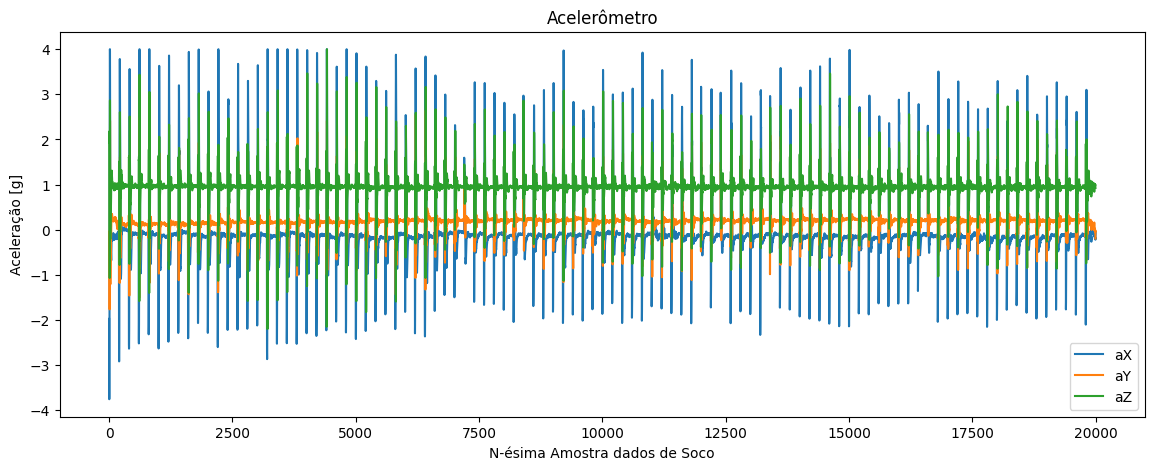

In [ ]:
plt.rcParams["figure.figsize"] = (14,5)

for i in range(len(dt_soco.columns[:3])):

  plt.plot(list(range(len(dt_soco[dt_soco.columns[:3][i]]))), dt_soco[dt_soco.columns[:3][i]], label = dt_soco.columns[:3][i])

plt.title("Acelerômetro")
plt.xlabel("N-ésima Amostra dados de Soco")
plt.ylabel("Aceleração [g]")

plt.legend()
plt.show()

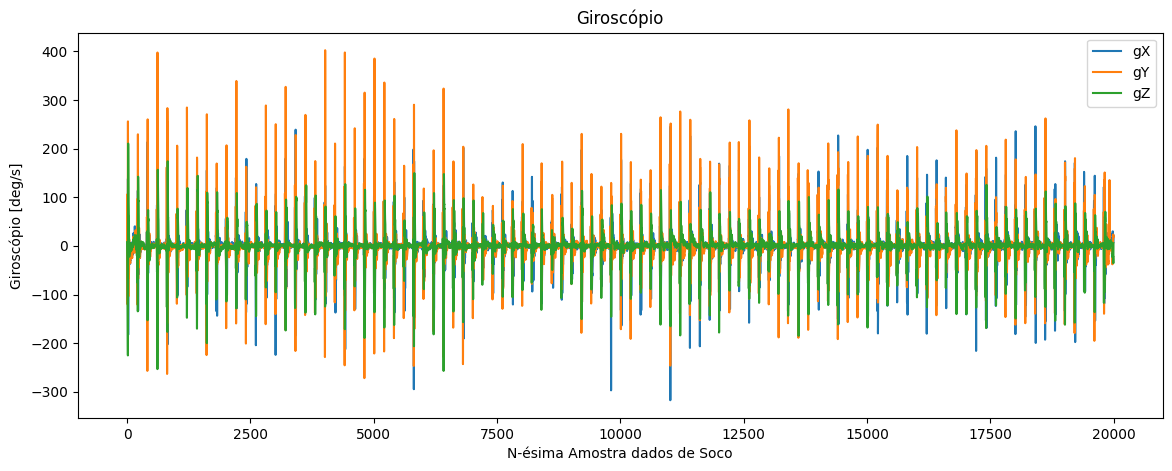

In [ ]:
plt.rcParams["figure.figsize"] = (14,5)

for i in range(len(dt_soco.columns[3:])):

  plt.plot(list(range(len(dt_soco[dt_soco.columns[3:][i]]))), dt_soco[dt_soco.columns[3:][i]], label = dt_soco.columns[3:][i])

plt.title("Giroscópio")
plt.xlabel("N-ésima Amostra dados de Soco")
plt.ylabel("Giroscópio [deg/s]")

plt.legend()
plt.show()

### Normalização dos dados e finalização dos `dataframes (df)`

Define o alcance máximo dos dados do acelerômetro e do giroscópio para normalização dos dados

In [ ]:
acceleration_range = (-4, 4)
gyroscope_range    = (-2000, 2000)

Aplicação da função `normalize_df` para manter os dados em um intervalo de 0 a 1 com base no range padrão dos componentes

In [ ]:
df_soco_norm = normalize_df(dt_soco, acceleration_range, gyroscope_range)

df_felxao_norm = normalize_df(dt_felxao, acceleration_range, gyroscope_range)

df_direita_norm = normalize_df(dt_direita, acceleration_range, gyroscope_range)

df_esquerda_norm = normalize_df(dt_esquerda, acceleration_range, gyroscope_range)

### Criação dos dados de entrada e de saída

Salva os dfs em uma variável única

In [ ]:
dataframes = [df_soco_norm, df_felxao_norm, df_direita_norm, df_esquerda_norm]

In [ ]:
df_soco_norm

,aX,aY,aZ,gX,gY,gZ
0,0.252750,0.484750,0.741500,0.516907,0.525925,0.501907
1,0.192250,0.490500,0.760000,0.513657,0.526383,0.500122
2,0.126375,0.495125,0.769625,0.509491,0.523163,0.497986
3,0.066875,0.485250,0.772000,0.506302,0.518479,0.495697
4,0.030250,0.467875,0.770250,0.504166,0.511413,0.492737
...,...,...,...,...,...,...
19995,0.490750,0.493000,0.625125,0.505661,0.505814,0.492966
19996,0.493625,0.495750,0.620750,0.505401,0.505630,0.491562
19997,0.490875,0.498000,0.624125,0.505493,0.504517,0.491089
19998,0.472375,0.482625,0.620500,0.505356,0.504379,0.493088


Aplica o `One-Hot-Encoded (OHE)` na variável que recebe o nome de cada gesto e printa a matriz com os binários

In [ ]:
gestos = ['Soco', 'Flexao', 'Direita', 'Esquerda']

OHE_gestos = np.eye(len(gestos))

print(OHE_gestos)

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


Percorre os dfs e a matriz OHE e gera os dados de entrada `X` e de saída `Y`

In [ ]:
entradas = []
saidas   = []

amostras_gestos = 200

for i, df in enumerate(dataframes):

    num_recordings = df.shape[0] // amostras_gestos
    saida_gesto = OHE_gestos[i]

    for j in range(num_recordings):

        tensor = df.values[j * amostras_gestos: (j + 1) * amostras_gestos].flatten().tolist()

        entradas.append(tensor)
        saidas.append(saida_gesto.tolist())

X = np.array(entradas)
Y = np.array(saidas)

print(f"Entradas (X) shape: {X.shape}")
print(f"Saídas   (Y) shape: {Y.shape}")

Entradas (X) shape: (400, 1200)
Saídas   (Y) shape: (400, 4)


Faz toda a divisão dos dados para `Treino`, `Teste` e `Validação`

In [ ]:
divisao_treino = 0.70
divisao_valida = 0.20
divisao_testes = 0.10

X_train, X_temp, y_train, y_temp = train_test_split(X, Y, test_size = (divisao_testes + divisao_valida), shuffle=True)

taxa_divisao_valid = divisao_valida / (divisao_testes + divisao_valida)

X_test, X_validate, y_test, y_validate = train_test_split(X_temp, y_temp, test_size = taxa_divisao_valid, shuffle=True)

print(f"Shape dos dados de treinamento: {X_train.shape}")
print(f"Shape dos dados de validação:   {X_validate.shape}")
print(f"Shape dos dados de teste:       {X_test.shape}")

Shape dos dados de treinamento: (279, 1200)
Shape dos dados de validação:   (81, 1200)
Shape dos dados de teste:       (40, 1200)


### Gera, treina e o modelo `Dense Neural Network (DNN)` ou Rede Neural Densa

Definição de alguns argumentos
>*batch_size* : tamanho dos "pacotes" de aprendizado
<br>*epocas* : número de épocas para os treinamentos
<br>*taxa_aprendizado* : taxa de aprendizado de máquina
<br>*loss* : taxa ou o quanto a rede neural erra

#### Modelo 1:
>*Otimizador: Adam*
<br>*Loss: Categorical Crossentropy*
<br>*Métrica: accuracy*
<br>*Batch_size: 1*
<br>*Épocas: 50*
<br>*Learning_rate: 0.001*
<br>*Camadas: 2 - 128 Neurônios | 4 Neurônios*

In [ ]:
batch_size_Adam = 1
epocas_Adam = 50
taxa_aprendizado_Adam = 0.001

Criação dos datasets

In [ ]:
dataset_train_Adam    = create_dataset(X_train,    y_train,    batch_size_Adam)
dataset_test_Adam     = create_dataset(X_test,     y_test,     batch_size_Adam)
dataset_validate_Adam = create_dataset(X_validate, y_validate, batch_size_Adam)

Cria o modelo 1

In [ ]:
warnings.filterwarnings("ignore", category=UserWarning)

DNN_model_Adam = tf.keras.models.Sequential([

    tf.keras.layers.Input(shape = (X_train.shape[1],)),

    # Construção dos neurônios
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(y_train.shape[1], activation = 'softmax')

])

DNN_model_Adam.compile(

    optimizer = tf.keras.optimizers.Adam(learning_rate = taxa_aprendizado_Adam),
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics = ['accuracy']

)

DNN_model_Adam.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_28 (Dense)                     │ (None, 128)                 │         153,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 154,244 (602.52 KB)

 Trainable params: 154,244 (602.52 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_DNN_Adam = DNN_model_Adam.fit(

    dataset_train_Adam,
    validation_data = dataset_validate_Adam,
    epochs = epocas_Adam

)

Epoch 1/50
279/279 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3194 - loss: 1.6975 - val_accuracy: 0.4691 - val_loss: 1.3174
Epoch 2/50
279/279 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3855 - loss: 1.3274 - val_accuracy: 0.2716 - val_loss: 1.2533
Epoch 3/50
279/279 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4673 - loss: 1.2246 - val_accuracy: 0.6296 - val_loss: 1.1379
Epoch 4/50
279/279 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5869 - loss: 1.0968 - val_accuracy: 0.4321 - val_loss: 1.0889
Epoch 5/50
279/279 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5717 - loss: 0.9759 - val_accuracy: 0.6420 - val_loss: 0.9584
Epoch 6/50
279/279 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6717 - loss: 0.9182 - val_accuracy: 0.6420 - val_loss: 0.8702
Epoch 7/50
279/279 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6817 - loss: 0.8399 - val_accuracy: 0.6420 - val_loss: 0.8236
Epoch 8/50
279/279 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7682 - loss: 0.8044 - val_accuracy: 0.

Faz uma avaliação do modelo com dados de teste

In [ ]:
dataset_test_loss_Adam, dataset_test_accuracy_Adam = DNN_model_Adam.evaluate(dataset_test_Adam)

classes_Adam = ['Loss', 'Acurácia']
indices_Adam = ['Valor']
acuracia_Adam = np.around(100*dataset_test_accuracy_Adam,2)

dados_tab_Adam = [[np.around(dataset_test_loss_Adam,4), f'{np.around(100*dataset_test_accuracy_Adam,2)}%']]

tabela_Adam = pd.DataFrame(dados_tab_Adam, index = indices_Adam, columns = classes_Adam)

display(tabela_Adam)

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9789 - loss: 0.1937


,Loss,Acurácia
Valor,0.1792,97.5%


Teste de fato com os dados de teste e obtém os valores `previstos`e `esperados`

In [ ]:
predictions_Adam = DNN_model_Adam.predict(X_test)
predictions_Adam = np.argmax(predictions_Adam, axis=1)

esperado_Adam = np.argmax(y_test, axis=1)

incremento = 0
previsao_Adam   = predictions_Adam

for i in range(len(previsao_Adam)):
  if previsao_Adam[i] == esperado_Adam[i]:
    incremento = incremento + 1

print('\nResultados Esperados: %s' % esperado_Adam)
print('\nResultados Previstos: %s' % predictions_Adam)
print('\nTeste teve {}% de aproveitamento\n'.format(round((incremento/len(previsao_Adam))*100,2)))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

Resultados Esperados: [1 0 3 3 2 0 1 0 1 2 2 3 3 3 3 3 1 2 1 3 2 0 1 1 0 2 0 3 2 0 1 3 0 0 2 1 0
 3 1 3]

Resultados Previstos: [1 2 3 3 2 0 1 0 1 2 2 3 3 3 3 3 1 2 1 3 2 0 1 1 0 2 0 3 2 0 1 3 0 0 2 1 0
 3 1 3]

Teste teve 97.5% de aproveitamento



Salva o histórico do treinamento no próprio ambiente

In [ ]:
with open('/content/history_DNN_Adam.pkl', 'wb') as f:
  pic.dump(history_DNN_Adam.history, f)

print(f"Histórico de treinamento salvo no Colab")

Histórico de treinamento salvo no Colab


Abre o histórico do treinamento

In [ ]:
with open('/content/history_DNN_Adam.pkl', 'rb') as f:
  loaded_history_Adam = pic.load(f)

print(f"Histórico de treinamento carregado do Colab")

Histórico de treinamento carregado do Colab


Armazena nas variáveis as `acurácias` e `losses` de treino e validação

In [ ]:
acuracia_treino_Adam = loaded_history_Adam['accuracy']
acuracia_valida_Adam = loaded_history_Adam['val_accuracy']

loss_treino_Adam = loaded_history_Adam['loss']
loss_valida_Adam = loaded_history_Adam['val_loss']

Plot do aprendizado do modelo

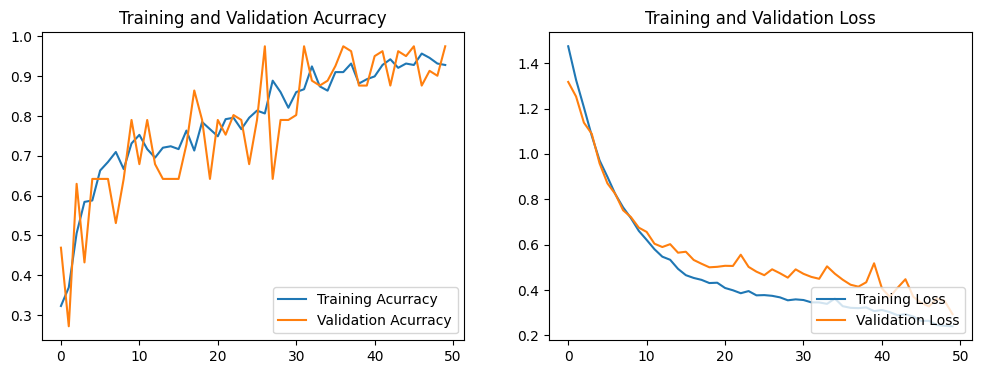

In [ ]:
plot_model(acuracia_treino_Adam, acuracia_valida_Adam, loss_treino_Adam, loss_valida_Adam, epocas_Adam, 'Acurracy')

Matriz de confusão para os resultados obtidos

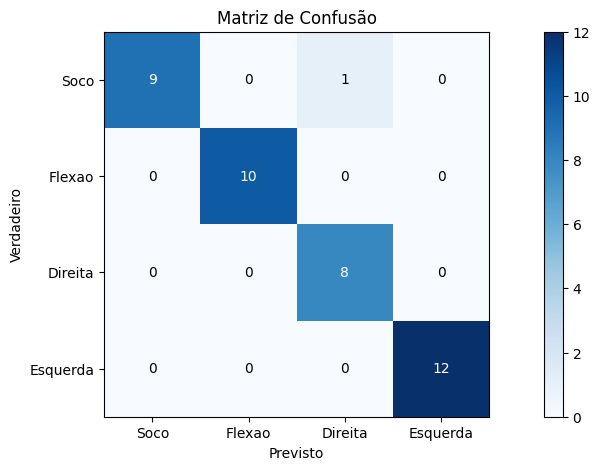

In [ ]:
y_true_Adam = esperado_Adam
y_pred_Adam = previsao_Adam

matriz_confusao(y_true_Adam, y_pred_Adam, gestos)

#####<font size = 4> Converte o modelo treinado em <font size = 5>`DNN_model_Adam.h`

In [ ]:
nome_modelo = 'DNN_model_Adam'
data_modelo =  DNN_model_Adam

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(data_modelo)
tflite_model = converter.convert()

open("gesture_model.tflite", "wb").write(tflite_model)

basic_model_size = os.path.getsize("gesture_model.tflite")
print("Model is %d bytes" % basic_model_size)

Saved artifact at '/tmp/tmpzb68k18a'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 1200), dtype=tf.float32, name='keras_tensor_42')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  140328521589936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140328506072352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140328506072000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140328506073936: TensorSpec(shape=(), dtype=tf.resource, name=None)
Model is 618708 bytes


In [ ]:
!echo "const unsigned char model[] = {" > /content/DNN_model_Adam.h
!cat gesture_model.tflite | xxd -i      >> /content/DNN_model_Adam.h
!echo "};"                              >> /content/DNN_model_Adam.h

import os

data_modelo_size = os.path.getsize(f"{nome_modelo}.h")
print(f"Header file, {nome_modelo}.h, is {data_modelo_size:,} bytes.")
print(f"\nOpen the side panel (refresh if needed). Double click {nome_modelo}.h to download the file.")

Header file, DNN_model_Adam.h, is 3,815,400 bytes.

Open the side panel (refresh if needed). Double click DNN_model_Adam.h to download the file.


#### Modelo 2:
>*Otimizador: SGD*
<br>*Loss: Mean Squared Error*
<br>*Métrica: mae*
<br>*Batch_size: 1*
<br>*Épocas: 50*
<br>*Learning_rate: 0.001*
<br>*Camadas: 2 - 128 Neurônios | 4 Neurônios*

In [ ]:
batch_size_SGD = 1
epocas_SGD = 50
taxa_aprendizado_SGD = 0.001

In [ ]:
dataset_train_SGD    = create_dataset(X_train,    y_train,    batch_size_SGD)
dataset_test_SGD     = create_dataset(X_test,     y_test,     batch_size_SGD)
dataset_validate_SGD = create_dataset(X_validate, y_validate, batch_size_SGD)

In [ ]:
warnings.filterwarnings("ignore", category=UserWarning)

DNN_model_SGD = tf.keras.models.Sequential([

    tf.keras.layers.Input(shape = (X_train.shape[1],)),

    # Construção dos neurônios
    tf.keras.layers.Dense(128, activation = 'relu',),
    tf.keras.layers.Dense(y_train.shape[1], activation = 'softmax')

])

DNN_model_SGD.compile(

    optimizer = tf.keras.optimizers.SGD(learning_rate = taxa_aprendizado_SGD),
    loss = tf.keras.losses.MeanSquaredError(),
    metrics = ['mae']

)

DNN_model_SGD.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_30 (Dense)                     │ (None, 128)                 │         153,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 154,244 (602.52 KB)

 Trainable params: 154,244 (602.52 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_DNN_SGD = DNN_model_SGD.fit(

    dataset_train_SGD,
    validation_data = dataset_validate_SGD,
    epochs = epocas_SGD

)

Epoch 1/50
279/279 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.2083 - mae: 0.3849 - val_loss: 0.1864 - val_mae: 0.3720
Epoch 2/50
279/279 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1896 - mae: 0.3760 - val_loss: 0.1874 - val_mae: 0.3737
Epoch 3/50
279/279 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1851 - mae: 0.3719 - val_loss: 0.1835 - val_mae: 0.3708
Epoch 4/50
279/279 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1827 - mae: 0.3698 - val_loss: 0.1809 - val_mae: 0.3683
Epoch 5/50
279/279 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1806 - mae: 0.3676 - val_loss: 0.1816 - val_mae: 0.3684
Epoch 6/50
279/279 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1801 - mae: 0.3671 - val_loss: 0.1803 - val_mae: 0.3671
Epoch 7/50
279/279 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1760 - mae: 0.3623 - val_loss: 0.1769 - val_mae: 0.3636
Epoch 8/50
279/279 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1760 - mae: 0.3628 - val_loss: 0.1759 - val_mae: 0.3625
Epoch 9/50
279/279 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - lo

In [ ]:
results_SGD = DNN_model_SGD.evaluate(dataset_test_SGD, verbose=0)

dataset_test_loss_SGD = results_SGD[0]
dataset_test_mae_SGD  = results_SGD[1]

dados_tab_SGD = [[np.around(dataset_test_loss_SGD, 4), np.around(dataset_test_mae_SGD, 4)]]

classes_SGD = ['Loss', 'MAE']
indices_SGD = ['Valor']

tabela_SGD = pd.DataFrame(dados_tab_SGD, index=indices_SGD, columns=classes_SGD)

display(tabela_SGD)

,Loss,MAE
Valor,0.0823,0.2388


In [ ]:
predictions_SGD = DNN_model_SGD.predict(X_test)
predictions_SGD = np.argmax(predictions_SGD, axis=1)

esperado_SGD = np.argmax(y_test, axis=1)

incremento = 0
previsao_SGD = predictions_SGD

for i in range(len(previsao_SGD)):
  if previsao_SGD[i] == esperado_SGD[i]:
    incremento = incremento + 1

print('\nResultados Esperados: %s' % esperado_SGD)
print('\nResultados Previstos: %s' % predictions_SGD)
print('\nTeste teve {}% de aproveitamento\n'.format(round((incremento/len(previsao_SGD))*100,2)))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

Resultados Esperados: [1 0 3 3 2 0 1 0 1 2 2 3 3 3 3 3 1 2 1 3 2 0 1 1 0 2 0 3 2 0 1 3 0 0 2 1 0
 3 1 3]

Resultados Previstos: [1 1 3 3 2 0 1 0 1 2 2 3 3 3 3 3 1 2 1 3 2 0 1 1 0 2 0 3 2 0 1 3 0 0 2 1 0
 3 1 3]

Teste teve 97.5% de aproveitamento



In [ ]:
with open('/content/history_DNN_SGD.pkl', 'wb') as f:
  pic.dump(history_DNN_SGD.history, f)

print(f"Histórico de treinamento salvo no Colab")

Histórico de treinamento salvo no Colab


In [ ]:
with open('/content/history_DNN_SGD.pkl', 'rb') as f:
  loaded_history_SGD = pic.load(f)

print(f"Histórico de treinamento carregado do Colab")

Histórico de treinamento carregado do Colab


In [ ]:
mae_treino_SGD = loaded_history_SGD['mae']
mae_valida_SGD = loaded_history_SGD['val_mae']

loss_treino_SGD = loaded_history_SGD['loss']
loss_valida_SGD = loaded_history_SGD['val_loss']

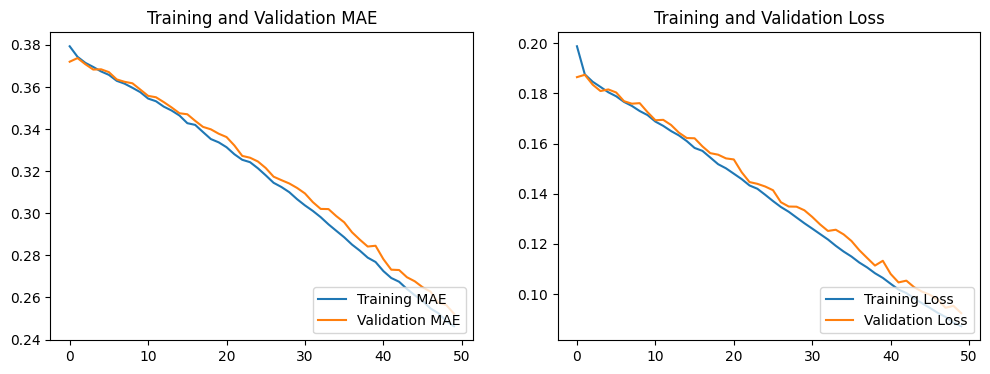

In [ ]:
plot_model(mae_treino_SGD, mae_valida_SGD, loss_treino_SGD, loss_valida_SGD, epocas_SGD, 'MAE')

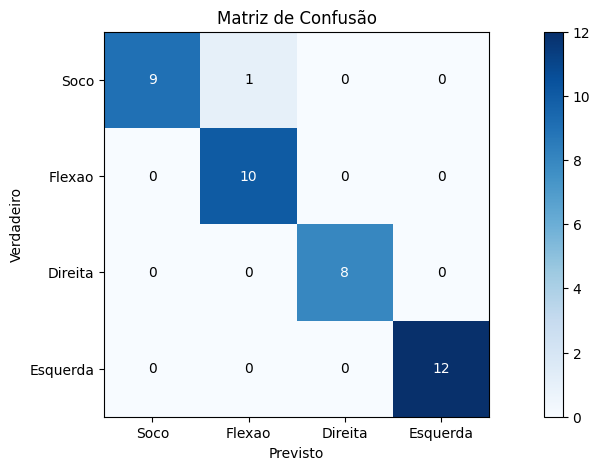

In [ ]:
y_true_SGD = esperado_SGD
y_pred_SGD = previsao_SGD

matriz_confusao(y_true_SGD, y_pred_SGD, gestos)

#####<font size = 4> Converte o modelo treinado em <font size = 5>`DNN_model_SGD.h`

In [ ]:
nome_modelo = 'DNN_model_SGD'
data_modelo =  DNN_model_SGD

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(data_modelo)
tflite_model = converter.convert()

open("gesture_model.tflite", "wb").write(tflite_model)

basic_model_size = os.path.getsize("gesture_model.tflite")
print("Model is %d bytes" % basic_model_size)

Saved artifact at '/tmp/tmpediu8606'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 1200), dtype=tf.float32, name='keras_tensor_45')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  140328503422192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140328503771376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140328503772960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140328503783520: TensorSpec(shape=(), dtype=tf.resource, name=None)
Model is 618708 bytes


In [ ]:
!echo "const unsigned char model[] = {" > /content/DNN_model_SGD.h
!cat gesture_model.tflite | xxd -i      >> /content/DNN_model_SGD.h
!echo "};"                              >> /content/DNN_model_SGD.h

import os

data_modelo_size = os.path.getsize(f"{nome_modelo}.h")
print(f"Header file, {nome_modelo}.h, is {data_modelo_size:,} bytes.")
print(f"\nOpen the side panel (refresh if needed). Double click {nome_modelo}.h to download the file.")

Header file, DNN_model_SGD.h, is 3,815,400 bytes.

Open the side panel (refresh if needed). Double click DNN_model_SGD.h to download the file.
